In [1]:
import pandas as pd
import numpy as np
from transformers import RobertaTokenizer, RobertaModel
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix  # new import for confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix  # new import for confusion matrix
import matplotlib.pyplot as plt

In [2]:
class IssueDataset(Dataset):
    """
    Dataset for processing text data and labels for classification.

    Args:
        texts (pd.Series): Series of input texts.
        labels (list or pd.Series): Corresponding labels (one-hot encoded).
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer for converting text to tokens.
        max_length (int): Maximum length of tokenized sequences (default is 512).

    Attributes:
        texts (pd.Series): Processed texts with reset indices.
        labels: Processed labels with reset indices (if pandas Series).
        tokenizer: Provided tokenizer instance.
        max_length (int): Maximum length for padding/truncation.
    """
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts.reset_index(drop=True)
        # Reset index for labels if it's a pandas Series.
        if isinstance(labels, pd.Series):
            self.labels = labels.reset_index(drop=True)
        else:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )
        label = self.labels[idx]
        if not isinstance(label, (list, np.ndarray)):
            label = [label]
        # Convert one-hot encoded label to class index
        label = int(np.argmax(label))
        return {
            'input_ids': encodings['input_ids'].flatten(),
            'attention_mask': encodings['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [3]:
class CodeBERTClassifier(nn.Module):
    """
    A classifier model based on CodeBERT for single-label classification.
    
    This model uses a pre-trained CodeBERT model as the encoder and adds a 
    classification head on top.
    
    Args:
        num_labels (int): Number of classes in the classification task.
    """
    def __init__(self, num_labels):
        super().__init__()
        self.codebert = RobertaModel.from_pretrained('microsoft/codebert-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)
        # Freeze all parameters in CodeBERT
        for param in self.codebert.parameters():
            param.requires_grad = False
        # Unfreeze pooler parameters for fine-tuning
        for param in self.codebert.pooler.parameters():
            param.requires_grad = True
        # Unfreeze parameters of the last 3 encoder layers
        for layer in self.codebert.encoder.layer[-3:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        # Return raw logits for CrossEntropyLoss
        return self.classifier(pooled_output)

In [4]:
class EarlyStopping:
    """
    Early stopping to stop training when the validation loss does not improve sufficiently.
    
    For single-label classification, we consider a loss improvement when 
    the validation loss decreases by at least min_delta.
    
    Args:
        patience (int): Number of epochs to wait for an improvement before stopping.
        min_delta (float): Minimum decrease in the monitored loss to qualify as an improvement.
    """
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def reset(self):
        """Reset the early stopping state."""
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

In [5]:

def train_epoch(model, loader, criterion, optimizer, device, early_stopping=None):
    """
    Train the model for one epoch, computing loss and accuracy, and apply early stopping if needed.

    Args:
        model (nn.Module): The classification model.
        loader (DataLoader): Training DataLoader.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        device: Device to perform training (CPU or GPU).
        early_stopping (EarlyStopping, optional): Instance to monitor improvement in loss.

    Returns:
        tuple: Average loss, accuracy, and a flag indicating if early stopping was triggered.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_elements = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).squeeze()  # Assumes labels are scalar indices
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predictions = torch.argmax(outputs, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_elements += labels.size(0)
    avg_loss = total_loss / len(loader)
    accuracy = total_correct / total_elements
    if early_stopping:
        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            return avg_loss, accuracy, True
    return avg_loss, accuracy, False
    

In [6]:

def validate(model, loader, criterion, device):
    """
    Evaluate the model on provided validation data.

    Args:
        model (nn.Module): The classification model.
        loader (DataLoader): Validation DataLoader.
        criterion: Loss function.
        device: Device to perform evaluation.

    Returns:
        tuple: Average loss, accuracy, precision, recall, and F1 score.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    return total_loss / len(loader), accuracy, precision, recall, f1


# Test 1 : Use all data

In [7]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/preprocessed-feature-issues/cleaned_data.json'
    data = pd.read_json(filepath)
    data = data[data.all_text != "nan"]
    data = data.explode('labels').reset_index(drop=True)

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))
    
    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test                  449
area/kubelet               172
area/apiserver             165
area/kubectl               154
area/e2e-test-framework     97
area/kubeadm                92
area/code-generation        80
area/cloudprovider          72
area/dependency             66
area/release-eng            28
area/conformance            26
area/provider/gcp           18
area/kube-proxy             17
area/provider/azure         14
area/ipvs                   11
area/network-policy          7
area/stable-metrics          5
area/admission-control       5
area/custom-resources        5
area/kubelet-api             5
area/ipv6                    4
area/logging                 3
area/provider/openstack      3
area/hw-accelerators         2
area/client-libraries        2
area/code-organization       2
area/etcd                    1
area/test-infra              1
area/security                1
area/batch                   1
area/worklo

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Training: 100%|██████████| 132/132 [00:48<00:00,  2.74it/s]


Epoch 1:
Train Loss: 2.6094, Train Accuracy: 0.2850
Val Loss: 2.4165, Val Accuracy: 0.3009
Val Precision: 0.0137, Val Recall: 0.0455, Val F1: 0.0210


Training: 100%|██████████| 132/132 [00:49<00:00,  2.64it/s]


Epoch 2:
Train Loss: 2.3205, Train Accuracy: 0.3229
Val Loss: 2.2502, Val Accuracy: 0.3451
Val Precision: 0.0517, Val Recall: 0.0836, Val F1: 0.0615


Training: 100%|██████████| 132/132 [00:53<00:00,  2.49it/s]


Epoch 3:
Train Loss: 2.0718, Train Accuracy: 0.4044
Val Loss: 2.1160, Val Accuracy: 0.3938
Val Precision: 0.1212, Val Recall: 0.1344, Val F1: 0.1220


Training: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]


Epoch 4:
Train Loss: 1.8664, Train Accuracy: 0.4697
Val Loss: 2.0207, Val Accuracy: 0.3894
Val Precision: 0.1289, Val Recall: 0.1672, Val F1: 0.1445


Training: 100%|██████████| 132/132 [00:52<00:00,  2.53it/s]


Epoch 5:
Train Loss: 1.7557, Train Accuracy: 0.4830
Val Loss: 1.9720, Val Accuracy: 0.3938
Val Precision: 0.1126, Val Recall: 0.1512, Val F1: 0.1277


Training: 100%|██████████| 132/132 [00:52<00:00,  2.51it/s]


Epoch 6:
Train Loss: 1.6804, Train Accuracy: 0.4886
Val Loss: 1.9997, Val Accuracy: 0.3761
Val Precision: 0.1088, Val Recall: 0.1466, Val F1: 0.1240


Training: 100%|██████████| 132/132 [00:52<00:00,  2.53it/s]


Epoch 7:
Train Loss: 1.6058, Train Accuracy: 0.4962
Val Loss: 1.9507, Val Accuracy: 0.3673
Val Precision: 0.1156, Val Recall: 0.1725, Val F1: 0.1336


Training: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]


Epoch 8:
Train Loss: 1.5450, Train Accuracy: 0.5076
Val Loss: 1.9834, Val Accuracy: 0.3673
Val Precision: 0.1090, Val Recall: 0.1419, Val F1: 0.1227


Training: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]


Epoch 9:
Train Loss: 1.4998, Train Accuracy: 0.5057
Val Loss: 2.0361, Val Accuracy: 0.3761
Val Precision: 0.1220, Val Recall: 0.1887, Val F1: 0.1423


Training: 100%|██████████| 132/132 [00:52<00:00,  2.52it/s]


Epoch 10:
Train Loss: 1.4363, Train Accuracy: 0.5142
Val Loss: 1.9935, Val Accuracy: 0.3363
Val Precision: 0.1122, Val Recall: 0.1655, Val F1: 0.1287
Test Loss: 2.1585
Test Accuracy: 0.3744
Test Precision: 0.1138
Test Recall: 0.1259
Test F1 Score: 0.1112

Label Frequencies on Test Set:
area/admission-control: 1
area/apiserver: 19
area/batch: 1
area/cloudprovider: 6
area/code-generation: 7
area/conformance: 8
area/custom-resources: 1
area/dependency: 14
area/e2e-test-framework: 22
area/ipvs: 2
area/kube-proxy: 4
area/kubeadm: 10
area/kubectl: 19
area/kubelet: 31
area/kubelet-api: 1
area/network-policy: 1
area/provider/azure: 3
area/provider/gcp: 1
area/provider/openstack: 1
area/release-eng: 5
area/stable-metrics: 1
area/test: 68
area/workload-api/job: 1


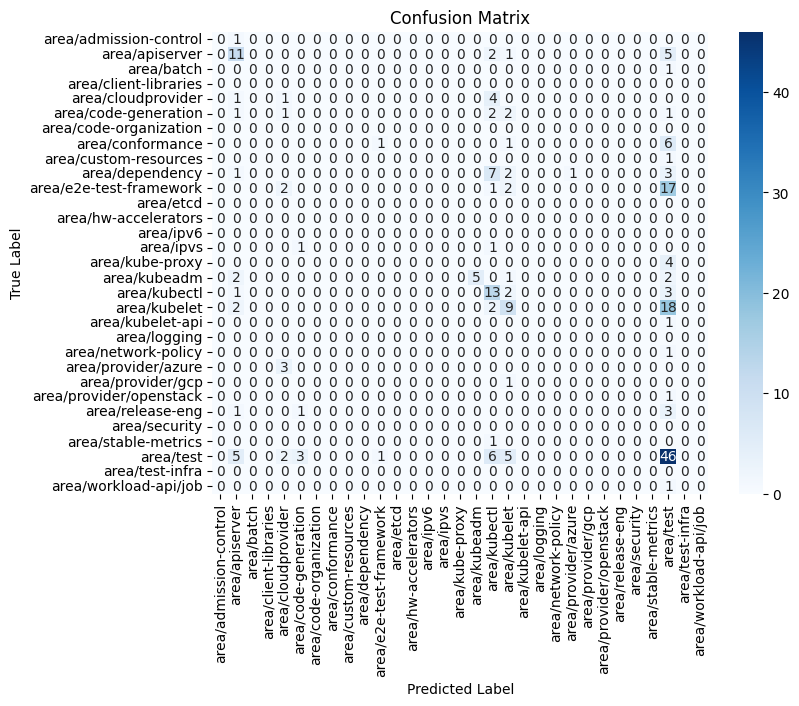

In [8]:
if __name__ == '__main__':
    main()

# Test 2 : Use all data where there are more than 10 samples per label

In [9]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/preprocessed-feature-issues/cleaned_data.json'
    data = pd.read_json(filepath)
    data = data[data.all_text != "nan"]
    label_freq = data.labels.apply(pd.Series).stack().value_counts()
    labels_to_keep = label_freq[label_freq > 10].index
    data = data[data.labels.apply(lambda x: any(label in labels_to_keep for label in x))]
    data = data.explode('labels').reset_index(drop=True)

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    
    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test                  449
area/kubelet               172
area/apiserver             165
area/kubectl               154
area/e2e-test-framework     97
area/kubeadm                92
area/code-generation        80
area/cloudprovider          72
area/dependency             66
area/release-eng            28
area/conformance            26
area/provider/gcp           18
area/kube-proxy             17
area/provider/azure         14
area/ipvs                   11
area/network-policy          7
area/admission-control       5
area/stable-metrics          5
area/kubelet-api             4
area/logging                 3
area/custom-resources        2
area/etcd                    1
area/security                1
area/test-infra              1
area/code-organization       1
area/batch                   1
area/workload-api/job        1
Name: count, dtype: int64


Training: 100%|██████████| 131/131 [00:52<00:00,  2.50it/s]


Epoch 1:
Train Loss: 2.5248, Train Accuracy: 0.3024
Val Loss: 2.4805, Val Accuracy: 0.2589
Val Precision: 0.0129, Val Recall: 0.0500, Val F1: 0.0206


Training: 100%|██████████| 131/131 [00:51<00:00,  2.53it/s]


Epoch 2:
Train Loss: 2.2755, Train Accuracy: 0.3206
Val Loss: 2.2927, Val Accuracy: 0.2902
Val Precision: 0.0380, Val Recall: 0.0748, Val F1: 0.0460


Training: 100%|██████████| 131/131 [00:51<00:00,  2.52it/s]


Epoch 3:
Train Loss: 2.0260, Train Accuracy: 0.4124
Val Loss: 2.1159, Val Accuracy: 0.3839
Val Precision: 0.1087, Val Recall: 0.1454, Val F1: 0.1194


Training: 100%|██████████| 131/131 [00:51<00:00,  2.52it/s]


Epoch 4:
Train Loss: 1.8200, Train Accuracy: 0.4670
Val Loss: 2.0231, Val Accuracy: 0.4018
Val Precision: 0.1563, Val Recall: 0.1837, Val F1: 0.1671


Training: 100%|██████████| 131/131 [00:51<00:00,  2.53it/s]


Epoch 5:
Train Loss: 1.7023, Train Accuracy: 0.4909
Val Loss: 2.0127, Val Accuracy: 0.4152
Val Precision: 0.1652, Val Recall: 0.1843, Val F1: 0.1732


Training: 100%|██████████| 131/131 [00:52<00:00,  2.52it/s]


Epoch 6:
Train Loss: 1.6332, Train Accuracy: 0.4995
Val Loss: 2.0539, Val Accuracy: 0.3884
Val Precision: 0.1575, Val Recall: 0.1617, Val F1: 0.1550


Training: 100%|██████████| 131/131 [00:51<00:00,  2.52it/s]


Epoch 7:
Train Loss: 1.5623, Train Accuracy: 0.4986
Val Loss: 2.0461, Val Accuracy: 0.3839
Val Precision: 0.1438, Val Recall: 0.1549, Val F1: 0.1450


Training: 100%|██████████| 131/131 [00:51<00:00,  2.52it/s]


Epoch 8:
Train Loss: 1.5093, Train Accuracy: 0.5110
Val Loss: 2.0545, Val Accuracy: 0.3839
Val Precision: 0.1340, Val Recall: 0.1465, Val F1: 0.1349


Training: 100%|██████████| 131/131 [00:51<00:00,  2.53it/s]


Epoch 9:
Train Loss: 1.4338, Train Accuracy: 0.5254
Val Loss: 2.0930, Val Accuracy: 0.3482
Val Precision: 0.1035, Val Recall: 0.1349, Val F1: 0.1146


Training: 100%|██████████| 131/131 [00:51<00:00,  2.53it/s]


Epoch 10:
Train Loss: 1.3854, Train Accuracy: 0.5321
Val Loss: 2.1487, Val Accuracy: 0.3527
Val Precision: 0.1318, Val Recall: 0.1449, Val F1: 0.1359
Test Loss: 2.1004
Test Accuracy: 0.3884
Test Precision: 0.1739
Test Recall: 0.1862
Test F1 Score: 0.1778

Label Frequencies on Test Set:
area/apiserver: 26
area/cloudprovider: 10
area/code-generation: 14
area/conformance: 2
area/custom-resources: 1
area/dependency: 12
area/e2e-test-framework: 18
area/ipvs: 3
area/kube-proxy: 3
area/kubeadm: 10
area/kubectl: 26
area/kubelet: 25
area/kubelet-api: 1
area/logging: 1
area/network-policy: 2
area/provider/azure: 1
area/provider/gcp: 2
area/release-eng: 3
area/test: 64


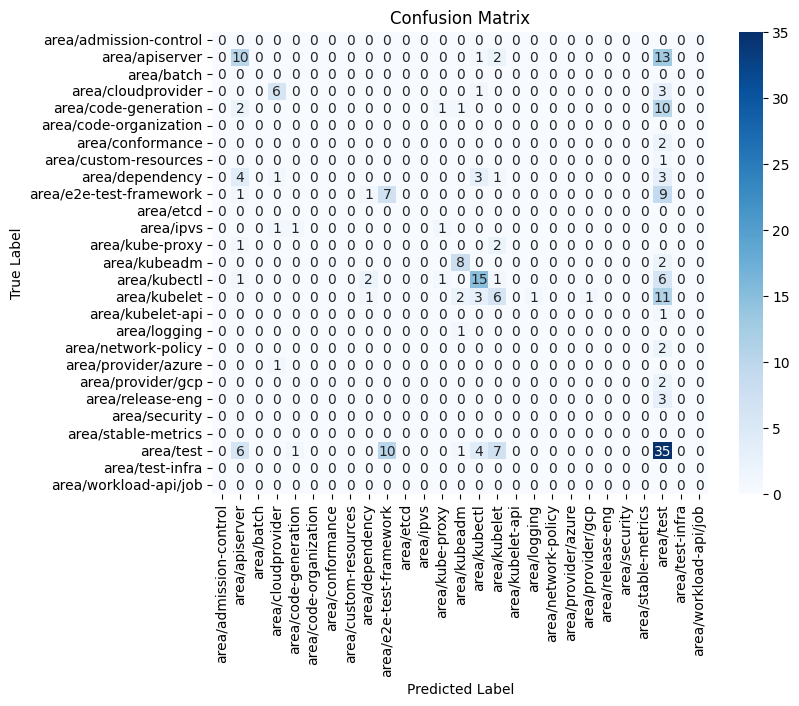

In [10]:
if __name__ == '__main__':
    main()

# Test 3 : Only retain data that have 1 labels

In [11]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/preprocessed-feature-issues/cleaned_data.json'
    data = pd.read_json(filepath)
    data = data[data.all_text != "nan"]
    data = data[data.labels.apply(len) <= 1]
    data = data.explode('labels').reset_index(drop=True)
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

Training: 100%|██████████| 44/44 [00:17<00:00,  2.51it/s]


Epoch 1:
Train Loss: 2.4918, Train Accuracy: 0.2800
Val Loss: 2.2087, Val Accuracy: 0.3333
Val Precision: 0.0238, Val Recall: 0.0714, Val F1: 0.0357


Training: 100%|██████████| 44/44 [00:17<00:00,  2.53it/s]


Epoch 2:
Train Loss: 2.0534, Train Accuracy: 0.3257
Val Loss: 2.1347, Val Accuracy: 0.3333
Val Precision: 0.0238, Val Recall: 0.0714, Val F1: 0.0357


Training: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch 3:
Train Loss: 1.8883, Train Accuracy: 0.4171
Val Loss: 1.7915, Val Accuracy: 0.5067
Val Precision: 0.2108, Val Recall: 0.1523, Val F1: 0.1184


Training: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch 4:
Train Loss: 1.5855, Train Accuracy: 0.5371
Val Loss: 1.5237, Val Accuracy: 0.6533
Val Precision: 0.1957, Val Recall: 0.2413, Val F1: 0.2140


Training: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch 5:
Train Loss: 1.2419, Train Accuracy: 0.7114
Val Loss: 1.3207, Val Accuracy: 0.7067
Val Precision: 0.2745, Val Recall: 0.2821, Val F1: 0.2713


Training: 100%|██████████| 44/44 [00:17<00:00,  2.54it/s]


Epoch 6:
Train Loss: 0.9715, Train Accuracy: 0.7800
Val Loss: 1.2017, Val Accuracy: 0.7200
Val Precision: 0.3298, Val Recall: 0.3313, Val F1: 0.3210


Training: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch 7:
Train Loss: 0.8123, Train Accuracy: 0.8029
Val Loss: 1.1805, Val Accuracy: 0.7067
Val Precision: 0.3231, Val Recall: 0.3297, Val F1: 0.3177


Training: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch 8:
Train Loss: 0.7060, Train Accuracy: 0.8286
Val Loss: 1.1512, Val Accuracy: 0.7067
Val Precision: 0.3363, Val Recall: 0.3150, Val F1: 0.3156


Training: 100%|██████████| 44/44 [00:17<00:00,  2.55it/s]


Epoch 9:
Train Loss: 0.5656, Train Accuracy: 0.8743
Val Loss: 1.1332, Val Accuracy: 0.7467
Val Precision: 0.3425, Val Recall: 0.3443, Val F1: 0.3339


Training: 100%|██████████| 44/44 [00:17<00:00,  2.56it/s]


Epoch 10:
Train Loss: 0.4844, Train Accuracy: 0.8743
Val Loss: 1.1453, Val Accuracy: 0.7600
Val Precision: 0.3494, Val Recall: 0.3490, Val F1: 0.3380
Test Loss: 1.1741
Test Accuracy: 0.7200
Test Precision: 0.3010
Test Recall: 0.3867
Test F1 Score: 0.3337

Label Frequencies on Test Set:
area/apiserver: 7
area/cloudprovider: 3
area/code-generation: 3
area/dependency: 2
area/hw-accelerators: 1
area/ipv6: 1
area/ipvs: 2
area/kube-proxy: 1
area/kubeadm: 12
area/kubectl: 12
area/kubelet: 5
area/provider/gcp: 3
area/release-eng: 1
area/test: 22


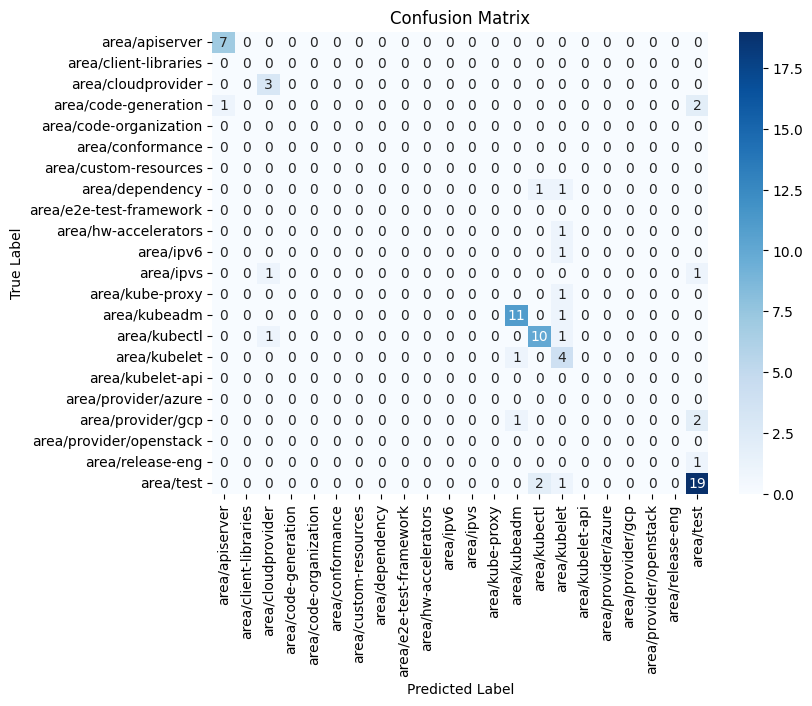

In [12]:
if __name__ == '__main__':
    main()

# Test 4 : Only retain data that have 1 labels and filter only use labels that have >10 rows

In [13]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/preprocessed-feature-issues/cleaned_data.json'
    data = pd.read_json(filepath)
    data = data[data.all_text != "nan"]
    data = data[data.labels.apply(len) <= 1]
    label_freq = data.labels.apply(pd.Series).stack().value_counts()
    labels_to_keep = label_freq[label_freq > 10].index
    data = data[data.labels.apply(lambda x: any(label in labels_to_keep for label in x))]
    data = data.explode('labels').reset_index(drop=True)
    # data.to_json('final_data.json', orient='records')

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())

    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    
    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test             161
area/kubectl           75
area/kubeadm           67
area/kubelet           64
area/apiserver         57
area/cloudprovider     22
Name: count, dtype: int64


Training: 100%|██████████| 39/39 [00:15<00:00,  2.51it/s]


Epoch 1:
Train Loss: 1.6724, Train Accuracy: 0.3462
Val Loss: 1.7347, Val Accuracy: 0.3731
Val Precision: 0.0622, Val Recall: 0.1667, Val F1: 0.0906


Training: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]


Epoch 2:
Train Loss: 1.6268, Train Accuracy: 0.3526
Val Loss: 1.6706, Val Accuracy: 0.4627
Val Precision: 0.1830, Val Recall: 0.2667, Val F1: 0.2057


Training: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]


Epoch 3:
Train Loss: 1.3840, Train Accuracy: 0.5160
Val Loss: 1.1765, Val Accuracy: 0.6567
Val Precision: 0.6795, Val Recall: 0.4966, Val F1: 0.4769


Training: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Epoch 4:
Train Loss: 1.0178, Train Accuracy: 0.6667
Val Loss: 0.9421, Val Accuracy: 0.7612
Val Precision: 0.6964, Val Recall: 0.6362, Val F1: 0.6107


Training: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Epoch 5:
Train Loss: 0.7118, Train Accuracy: 0.7885
Val Loss: 0.6975, Val Accuracy: 0.8209
Val Precision: 0.8163, Val Recall: 0.7816, Val F1: 0.7746


Training: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]


Epoch 6:
Train Loss: 0.5223, Train Accuracy: 0.8397
Val Loss: 0.5908, Val Accuracy: 0.8358
Val Precision: 0.8368, Val Recall: 0.7883, Val F1: 0.8003


Training: 100%|██████████| 39/39 [00:15<00:00,  2.53it/s]


Epoch 7:
Train Loss: 0.4167, Train Accuracy: 0.8718
Val Loss: 0.5222, Val Accuracy: 0.8657
Val Precision: 0.8617, Val Recall: 0.8530, Val F1: 0.8534


Training: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]


Epoch 8:
Train Loss: 0.3188, Train Accuracy: 0.9167
Val Loss: 0.5192, Val Accuracy: 0.8657
Val Precision: 0.8621, Val Recall: 0.8570, Val F1: 0.8509


Training: 100%|██████████| 39/39 [00:15<00:00,  2.55it/s]


Epoch 9:
Train Loss: 0.2470, Train Accuracy: 0.9231
Val Loss: 0.5797, Val Accuracy: 0.8507
Val Precision: 0.8929, Val Recall: 0.8021, Val F1: 0.8359


Training: 100%|██████████| 39/39 [00:15<00:00,  2.54it/s]


Epoch 10:
Train Loss: 0.1981, Train Accuracy: 0.9583
Val Loss: 0.5894, Val Accuracy: 0.8358
Val Precision: 0.8765, Val Recall: 0.7843, Val F1: 0.8139
Test Loss: 0.2081
Test Accuracy: 0.9254
Test Precision: 0.9345
Test Recall: 0.9121
Test F1 Score: 0.9195

Label Frequencies on Test Set:
area/apiserver: 9
area/cloudprovider: 3
area/kubeadm: 13
area/kubectl: 8
area/kubelet: 7
area/test: 27


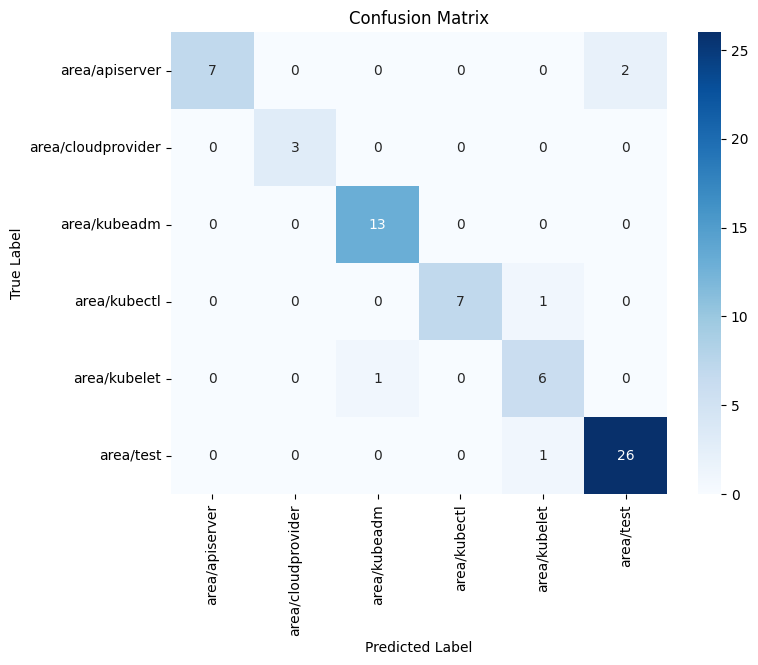

In [14]:
if __name__ == '__main__':
    main()

# Test 4 : Only retain data that have max 2 labels and filter only use labels that have >10 rows

In [15]:
def main():
    """
    Main function to execute the training and evaluation pipeline.

    Steps:
        1. Load and preprocess data.
        2. Initialize tokenizer and model.
        3. Create DataLoaders for training, validation, and testing.
        4. Train the model with early stopping.
        5. Validate and test the model, saving the best model.
    """
    # Load and preprocess data without showing intermediate outputs
    filepath = '/kaggle/input/preprocessed-feature-issues/cleaned_data.json'
    data = pd.read_json(filepath)
    data = data[data.all_text != "nan"]
    data = data[data.labels.apply(len) <= 2]
    label_freq = data.labels.apply(pd.Series).stack().value_counts()
    labels_to_keep = label_freq[label_freq > 10].index
    data = data[data.labels.apply(lambda x: any(label in labels_to_keep for label in x))]
    data = data.explode('labels').reset_index(drop=True)

    print("\nLabel Frequencies for Single-Label Classification:")
    print(data['labels'].value_counts())
    
    mlb = MultiLabelBinarizer()
    encoded_labels = mlb.fit_transform(data['labels'].apply(lambda x: [x]))
    num_labels = len(mlb.classes_)
    data_encoded = pd.DataFrame({
        'all_text': data['all_text'],
        'labels': list(encoded_labels)
    })
    
    # Split the data
    train = data_encoded.sample(frac=0.7, random_state=42)
    val = data_encoded.drop(train.index).sample(frac=0.5, random_state=42)
    test = data_encoded.drop(train.index).drop(val.index)
    train_data, train_labels = train['all_text'], train['labels']
    val_data, val_labels = val['all_text'], val['labels']
    test_data, test_labels = test['all_text'], test['labels']
    
    tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base')
    model = CodeBERTClassifier(num_labels).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    
    train_dataset = IssueDataset(train_data, train_labels, tokenizer)
    val_dataset = IssueDataset(val_data, val_labels, tokenizer)
    test_dataset = IssueDataset(test_data, test_labels, tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8)
    test_loader = DataLoader(test_dataset, batch_size=8)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    num_epochs = 10
    best_val_f1 = 0
    early_stopping = EarlyStopping(patience=3)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        train_loss, train_accuracy, early_stop = train_epoch(model, train_loader, criterion, optimizer, device, early_stopping)
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate(model, val_loader, criterion, device)
        print(f"Epoch {epoch + 1}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pt')
        if early_stop:
            break
            
    test_loss, test_accuracy, test_precision, test_recall, test_f1 = validate(model, test_loader, criterion, device)
    print("Test Loss: {:.4f}".format(test_loss))
    print("Test Accuracy: {:.4f}".format(test_accuracy))
    print("Test Precision: {:.4f}".format(test_precision))
    print("Test Recall: {:.4f}".format(test_recall))
    print("Test F1 Score: {:.4f}".format(test_f1))

    # Extra evaluation: Print label frequency and confusion matrix on test set
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print frequency of each label using original label names
    unique_label_indices, counts = np.unique(all_labels, return_counts=True)
    # Map indices to the original label names from the multi-label binarizer
    label_names = [mlb.classes_[i] for i in unique_label_indices]
    print("\nLabel Frequencies on Test Set:")
    for name, count in zip(label_names, counts):
        print(f"{name}: {count}")
    
    # Print confusion matrix with labeled axes
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_labels))
    cm_df = pd.DataFrame(cm, index=mlb.classes_, columns=mlb.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


Label Frequencies for Single-Label Classification:
labels
area/test                  343
area/kubelet               109
area/apiserver             102
area/kubectl               101
area/kubeadm                74
area/e2e-test-framework     63
area/cloudprovider          38
area/code-generation        22
area/dependency             19
area/conformance            15
area/provider/azure         12
area/release-eng             6
area/provider/gcp            4
area/kubelet-api             3
area/kube-proxy              2
area/ipvs                    2
area/admission-control       2
area/custom-resources        2
area/etcd                    1
area/security                1
area/test-infra              1
area/code-organization       1
area/stable-metrics          1
Name: count, dtype: int64


Training: 100%|██████████| 81/81 [00:32<00:00,  2.50it/s]


Epoch 1:
Train Loss: 2.3340, Train Accuracy: 0.3570
Val Loss: 2.2676, Val Accuracy: 0.2754
Val Precision: 0.0197, Val Recall: 0.0714, Val F1: 0.0308


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 2:
Train Loss: 2.0515, Train Accuracy: 0.3833
Val Loss: 2.1581, Val Accuracy: 0.2754
Val Precision: 0.0197, Val Recall: 0.0714, Val F1: 0.0308


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 3:
Train Loss: 1.7110, Train Accuracy: 0.4807
Val Loss: 1.5890, Val Accuracy: 0.5290
Val Precision: 0.2873, Val Recall: 0.3278, Val F1: 0.2966


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 4:
Train Loss: 1.3535, Train Accuracy: 0.5997
Val Loss: 1.3949, Val Accuracy: 0.5797
Val Precision: 0.2647, Val Recall: 0.3277, Val F1: 0.2916


Training: 100%|██████████| 81/81 [00:32<00:00,  2.51it/s]


Epoch 5:
Train Loss: 1.2068, Train Accuracy: 0.6306
Val Loss: 1.3801, Val Accuracy: 0.5870
Val Precision: 0.3158, Val Recall: 0.3641, Val F1: 0.3335


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 6:
Train Loss: 1.0862, Train Accuracy: 0.6491
Val Loss: 1.3469, Val Accuracy: 0.5870
Val Precision: 0.3067, Val Recall: 0.3618, Val F1: 0.3280


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 7:
Train Loss: 1.0484, Train Accuracy: 0.6785
Val Loss: 1.3538, Val Accuracy: 0.6014
Val Precision: 0.2864, Val Recall: 0.3311, Val F1: 0.3027


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 8:
Train Loss: 0.9930, Train Accuracy: 0.6646
Val Loss: 1.3757, Val Accuracy: 0.5652
Val Precision: 0.3124, Val Recall: 0.3560, Val F1: 0.3245


Training: 100%|██████████| 81/81 [00:32<00:00,  2.52it/s]


Epoch 9:
Train Loss: 0.9018, Train Accuracy: 0.6893
Val Loss: 1.3402, Val Accuracy: 0.5797
Val Precision: 0.3060, Val Recall: 0.3568, Val F1: 0.3278


Training: 100%|██████████| 81/81 [00:32<00:00,  2.53it/s]


Epoch 10:
Train Loss: 0.8746, Train Accuracy: 0.7032
Val Loss: 1.3139, Val Accuracy: 0.6014
Val Precision: 0.2752, Val Recall: 0.3390, Val F1: 0.3032
Test Loss: 1.4322
Test Accuracy: 0.5252
Test Precision: 0.2180
Test Recall: 0.2774
Test F1 Score: 0.2415

Label Frequencies on Test Set:
area/apiserver: 14
area/cloudprovider: 3
area/code-generation: 3
area/conformance: 1
area/dependency: 2
area/e2e-test-framework: 11
area/kubeadm: 11
area/kubectl: 15
area/kubelet: 11
area/kubelet-api: 2
area/provider/azure: 3
area/release-eng: 2
area/test: 60
area/test-infra: 1


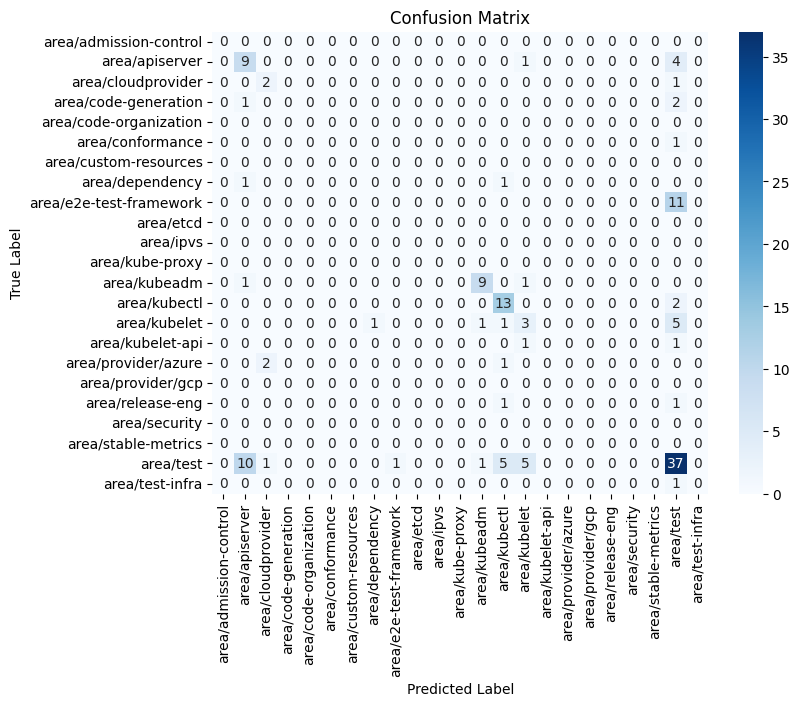

In [16]:
if __name__ == '__main__':
    main()